In [1]:
# ─── SETUP ──────────────────────────────────────────────────────────────
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from keras.models import load_model  # type: ignore

# Allow importing from parent dir
sys.path.append("..")

# Project modules
from src.data_loader import load_data
from src.visualization import (
    show_sample_images,
    show_predictions_with_gradcam,
    check_class_distribution,
    show_pneumonia_gradcam,
    compare_normal_vs_pneumonia_gradcam,
)

[DEBUG] data_loader.py loaded
Available symbols: ['ImageDataGenerator', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'load_data', 'os']


In [2]:
# ─── LOAD DATA AND MODELS ────────────────────────────────────────────────
data_dir = "../data/chest_xray"
train_gen, val_gen, test_gen = load_data(data_dir=data_dir, img_size=(224, 224), batch_size=32)

# Load models
base_model = load_model("../outputs/best_model.keras")
transfer_model = load_model("../outputs/best_transfer_model.keras")

# Confirm structure
print("Base model last conv layer:", base_model.layers[-4].name)
print("Transfer model last conv layer:", transfer_model.layers[-4].name)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Base model last conv layer: flatten
Transfer model last conv layer: out_relu


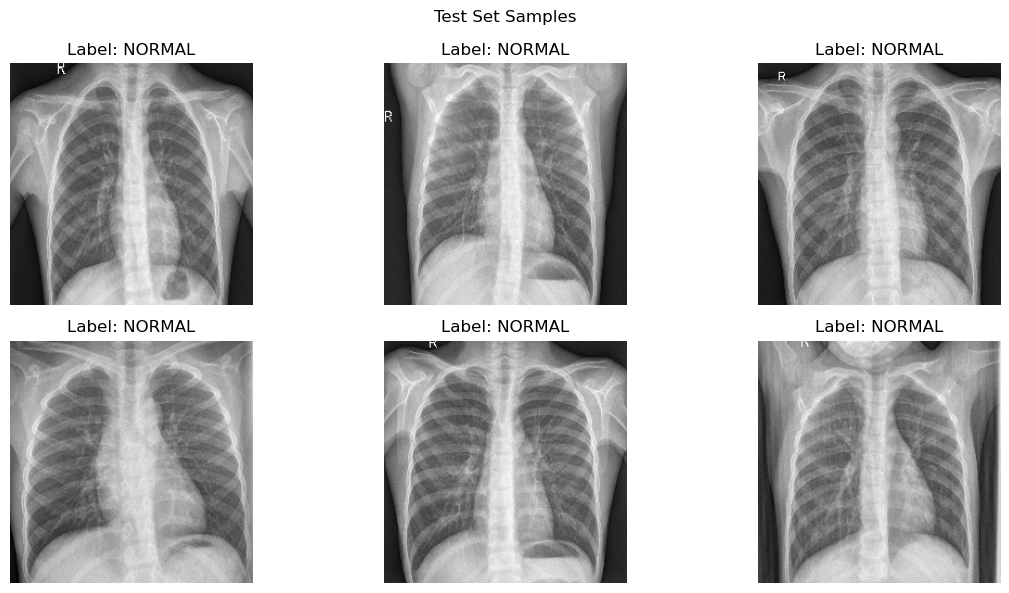

Checking class distribution in test set...
In 5 batches:
Normal cases: 160
Pneumonia cases: 0
Total: 160
⚠️ No pneumonia cases found in the sampled batches
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


/Users/georgetsoupras/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['input_layer']]. Received: the structure of inputs=*
  warnings.warn(


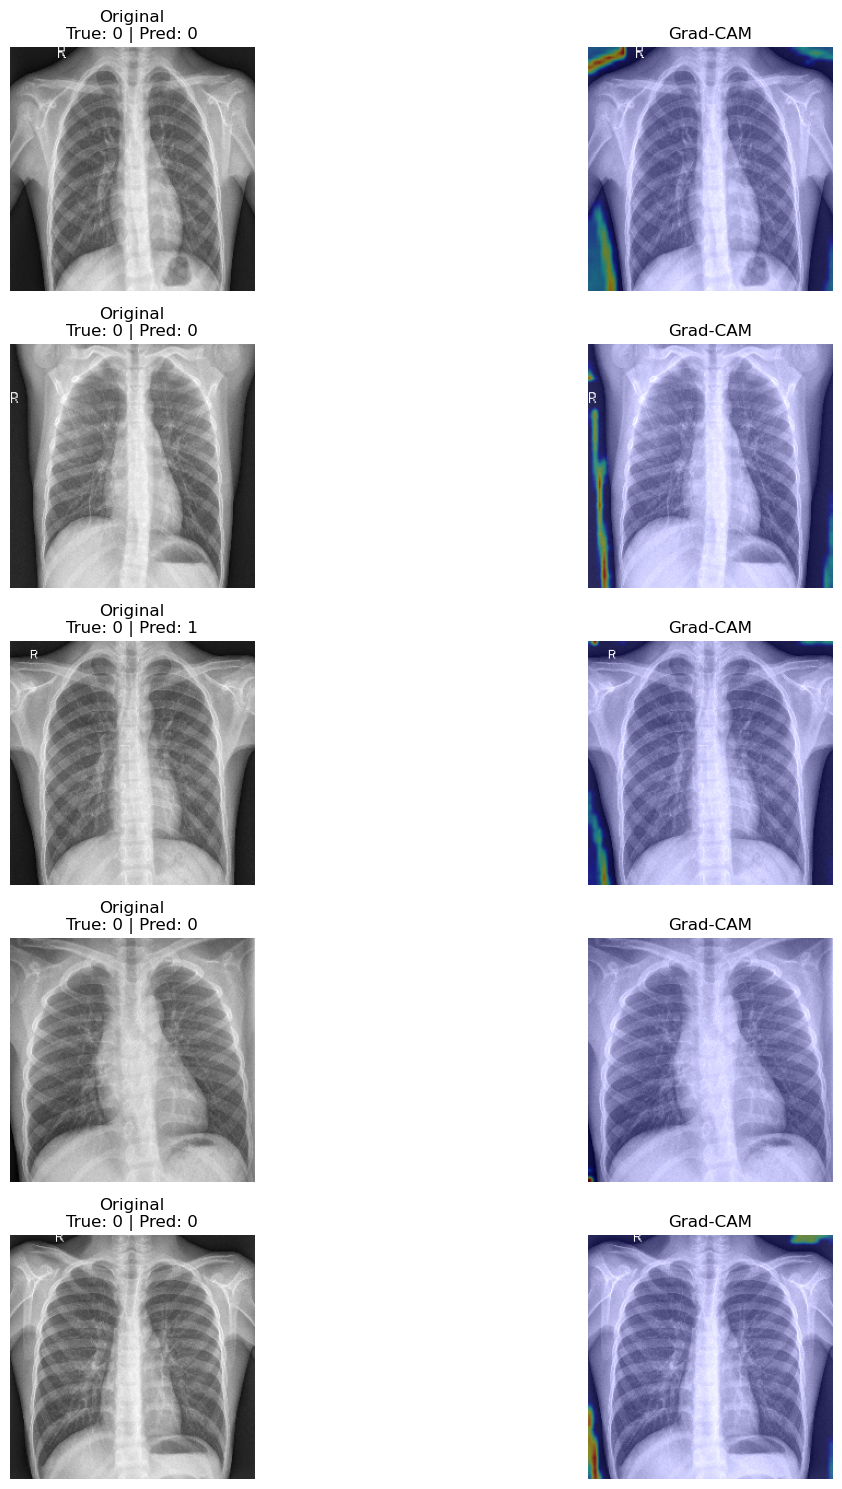

Searching for pneumonia cases...
Found 3 pneumonia cases and 3 normal cases
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


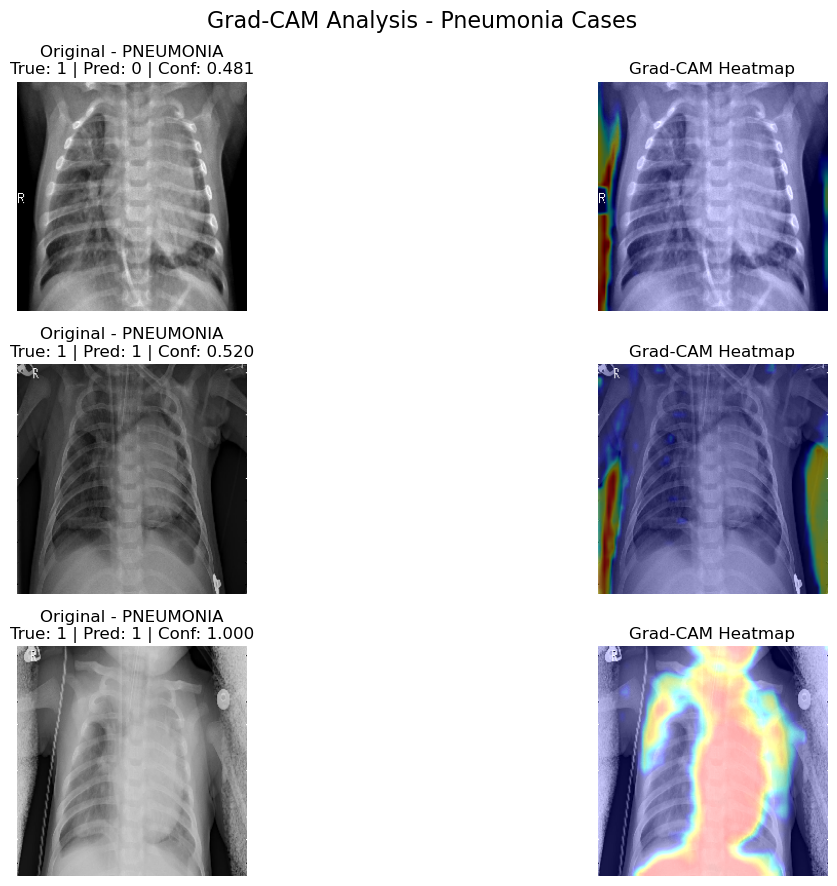

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


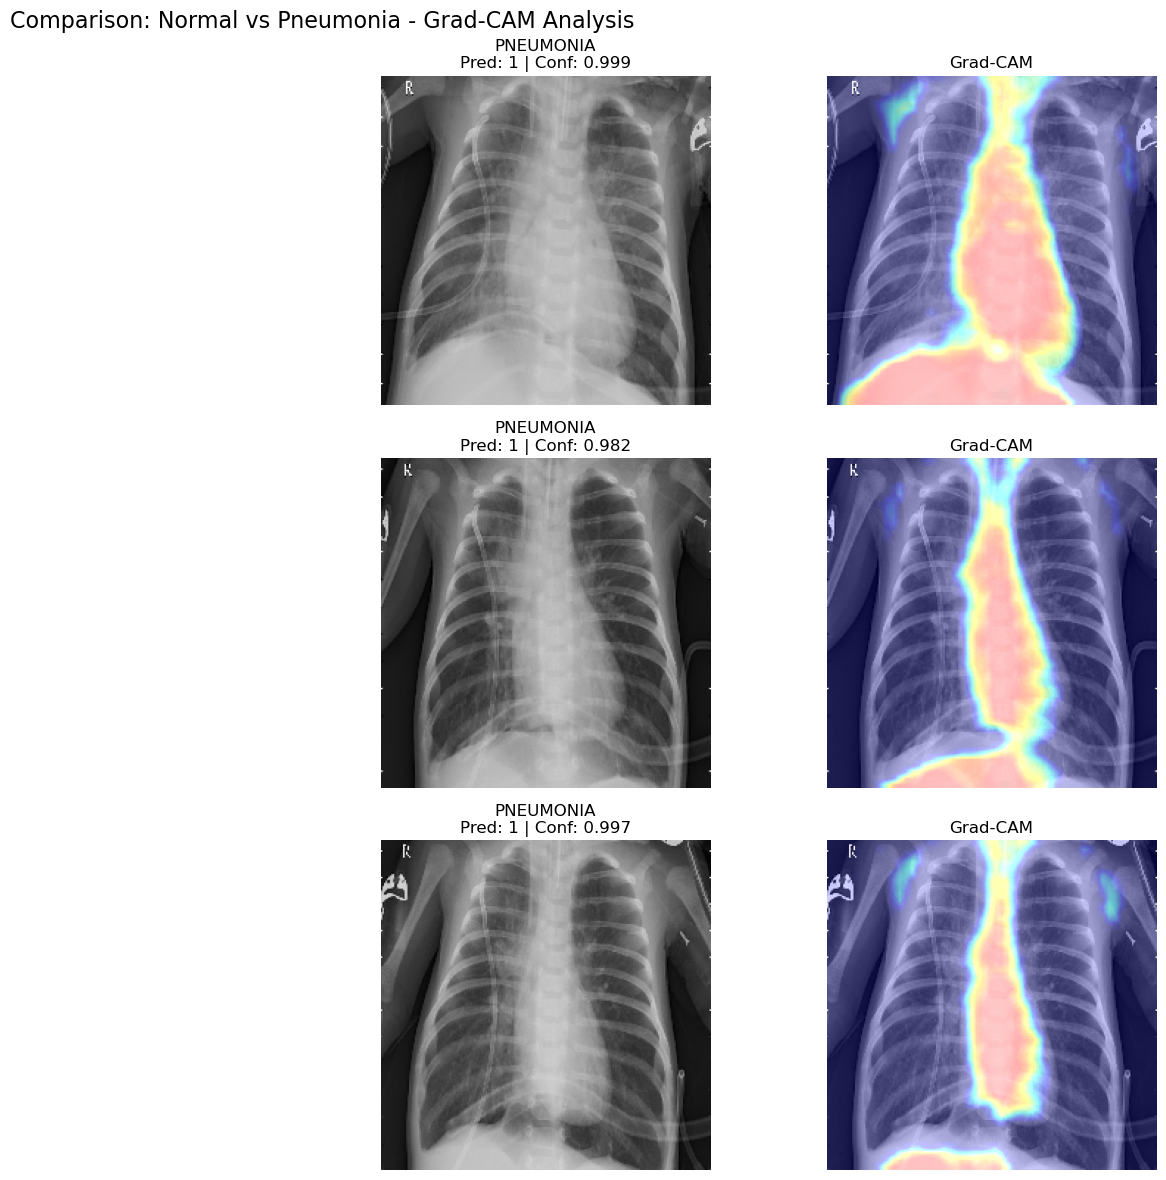

Checking class distribution in test set...
In 5 batches:
Normal cases: 96
Pneumonia cases: 48
Total: 144
✅ Found pneumonia cases - proceeding with Grad-CAM analysis
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


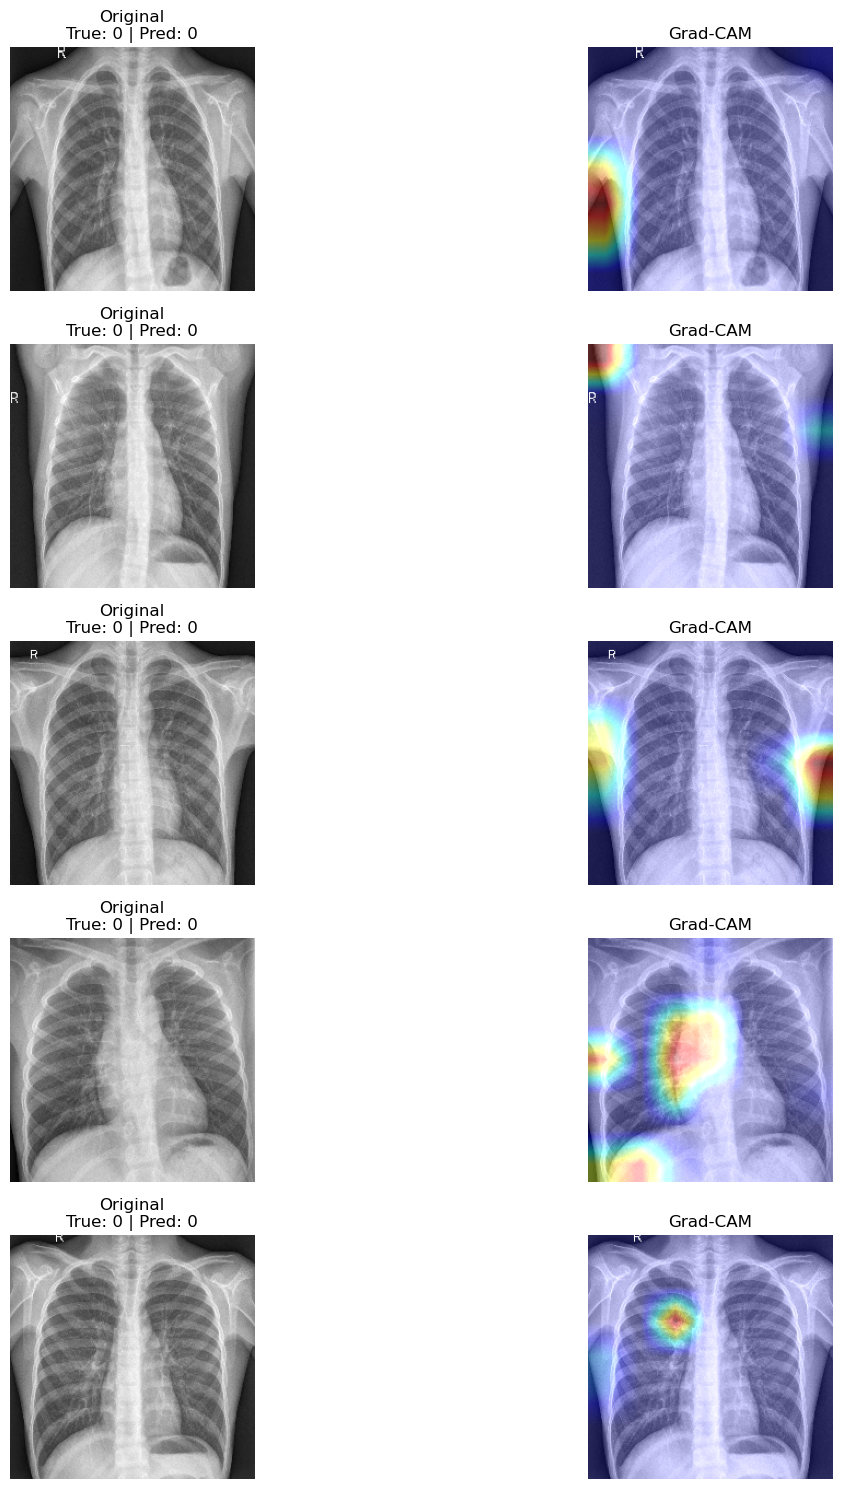

Searching for pneumonia cases...
Found 3 pneumonia cases and 3 normal cases
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


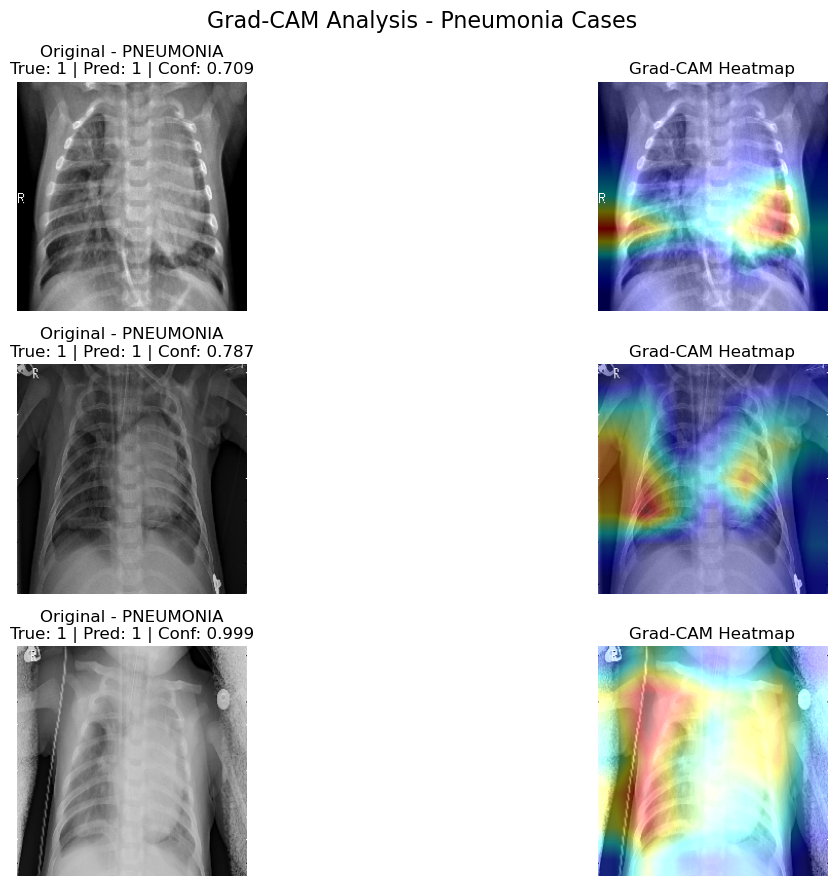

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


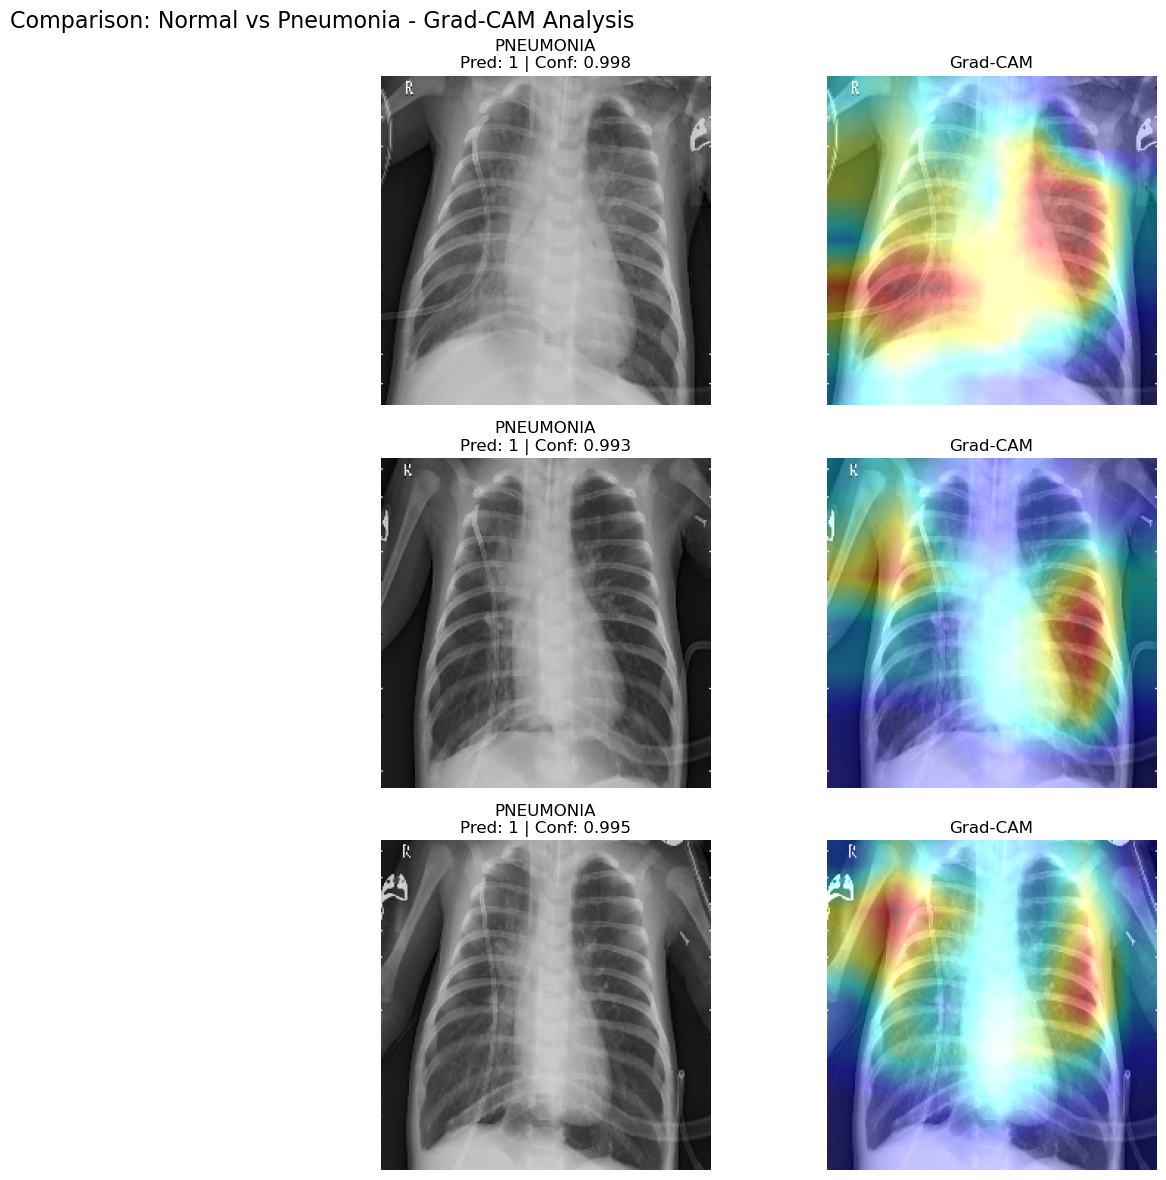

In [3]:
# ─── GRAD-CAM VISUALIZATION ──────────────────────────────────────────────
# Sample test images
show_sample_images(test_gen, test_gen.class_indices, title="Test Set Samples")

# Grad-CAM on base model
check_class_distribution(test_gen)
show_predictions_with_gradcam(base_model, test_gen, layer_name="last_conv")
show_pneumonia_gradcam(base_model, test_gen, layer_name="last_conv", num_images=3)
compare_normal_vs_pneumonia_gradcam(base_model, test_gen, layer_name="last_conv")

# Grad-CAM on transfer model
check_class_distribution(test_gen)
show_predictions_with_gradcam(transfer_model, test_gen, layer_name="out_relu")
show_pneumonia_gradcam(transfer_model, test_gen, layer_name="out_relu", num_images=3)
compare_normal_vs_pneumonia_gradcam(transfer_model, test_gen, layer_name="out_relu")

### ⚠️ Class Distribution Insight

During early evaluation, the initial test batches lacked any pneumonia cases, which could have led to misleading conclusions about model performance and Grad-CAM visualizations. This absence skewed both quantitative and interpretative metrics.

A subsequent batch, however, revealed a more realistic distribution: **96 normal** and **48 pneumonia** cases (out of 144 total). This balanced representation allowed for a more meaningful assessment of model sensitivity (true positive rate) and specificity (true negative rate).

**Key Takeaway:** Always inspect class distributions in test samples before evaluation. With imbalanced datasets like those in medical imaging, even subtle sampling artifacts can significantly distort model analysis and clinical applicability.


###  Grad-CAM Interpretation

Grad-CAM visualizations provided critical insight into how each model interprets pneumonia in chest X-rays.

- The **Transfer Learning model** consistently highlighted key pathological regions in pneumonia cases with strong, localized attention. This suggests a better grasp of spatial features relevant to the disease.
- In contrast, the **Base CNN** often produced more scattered or less targeted activations, which may correlate with its higher false negative rate observed during evaluation.

Furthermore, side-by-side comparisons of **normal vs pneumonia** cases using Grad-CAM underscored the improved focus of the transfer model.

**Why It Matters:** Visualization techniques like Grad-CAM are essential in medical AI to ensure that the model's decisions are based on clinically meaningful evidence — a step toward building trust in automated diagnostics.


In [4]:
# ─── EVALUATION FUNCTIONS ────────────────────────────────────────────────
def get_model_outputs(model, generator):
    generator.reset()
    probs = model.predict(generator).ravel()
    preds = (probs > 0.5).astype(int)
    true = generator.classes
    return true, probs, preds

def ensemble_predictions(prob_a, prob_b):
    probs = (prob_a + prob_b) / 2
    preds = (probs > 0.5).astype(int)
    return probs, preds

def compute_metrics(y_true, y_probs, y_preds):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    score = auc(fpr, tpr)
    cm = confusion_matrix(y_true, y_preds)
    return fpr, tpr, score, cm

def show_conf_matrix(cm, name, y_true, y_pred):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    print(f"{name} - False Positives: {fp}")
    print(f"{name} - False Negatives: {fn}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def show_all_conf_matrices(cm_b, cm_t, cm_e, y_true, pred_b, pred_t, ens_pred):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Define model names and corresponding confusion matrices
    conf_data = [
        ("Base CNN", cm_b, pred_b),
        ("Transfer Learning", cm_t, pred_t),
        ("Ensemble", cm_e, ens_pred)
    ]

    for ax, (title, cm, pred) in zip(axes, conf_data):
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                    xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
        ax.set_title(f"{title}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

        # Optional: print FP/FN
        fp = np.sum((pred == 1) & (y_true == 0))
        fn = np.sum((pred == 0) & (y_true == 1))
        print(f"{title}: FP = {fp}, FN = {fn}")

    plt.tight_layout()
    plt.show()


In [5]:
# ─── EVALUATE BASE + TRANSFER + ENSEMBLE ─────────────────────────────────
# Get outputs
y_true_b, prob_b, pred_b = get_model_outputs(base_model, test_gen)
y_true_t, prob_t, pred_t = get_model_outputs(transfer_model, test_gen)
ens_prob, ens_pred = ensemble_predictions(prob_b, prob_t)

# Metrics
fpr_b, tpr_b, auc_b, cm_b = compute_metrics(y_true_b, prob_b, pred_b)
fpr_t, tpr_t, auc_t, cm_t = compute_metrics(y_true_t, prob_t, pred_t)
fpr_e, tpr_e, auc_e, cm_e = compute_metrics(y_true_b, ens_prob, ens_pred)

/Users/georgetsoupras/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step


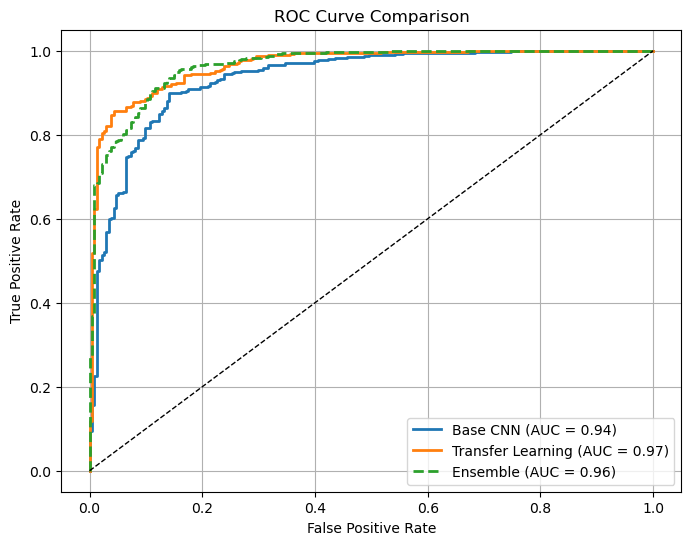

In [6]:
# ─── PLOT ROC CURVE ─────────────────────────────────────────────────────
plt.figure(figsize=(8, 6))
plt.plot(fpr_b, tpr_b, label=f'Base CNN (AUC = {auc_b:.2f})', lw=2)
plt.plot(fpr_t, tpr_t, label=f'Transfer Learning (AUC = {auc_t:.2f})', lw=2)
plt.plot(fpr_e, tpr_e, label=f'Ensemble (AUC = {auc_e:.2f})', linestyle='--', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [7]:
# # ─── SHOW CONFUSION MATRICES ────────────────────────────────────────────
# show_conf_matrix(cm_b, "Base CNN", y_true_b, pred_b)
# show_conf_matrix(cm_t, "Transfer Learning", y_true_t, pred_t)
# show_conf_matrix(cm_e, "Ensemble", y_true_b, ens_pred)

Base CNN: FP = 56, FN = 23
Transfer Learning: FP = 66, FN = 9
Ensemble: FP = 57, FN = 11


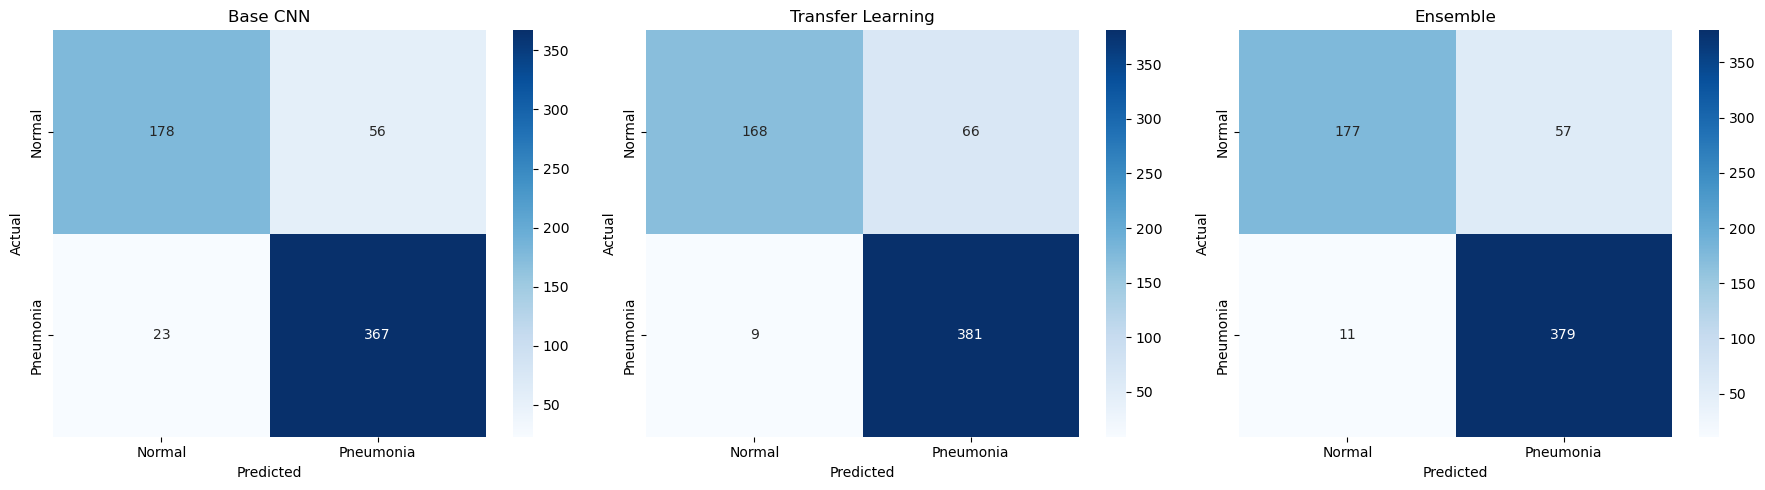

In [8]:
show_all_conf_matrices(cm_b, cm_t, cm_e, y_true_b, pred_b, pred_t, ens_pred)


### Model Evaluation Summary

The following summarizes the performance of the three evaluated models on the chest X-ray test set, focusing on classification metrics and error patterns:

---

#### Base CNN Model
- **AUC:** 0.94
- **False Positives (FP):** 56  
- **False Negatives (FN):** 23

The Base CNN model shows solid overall performance, with an AUC of **0.94**, suggesting good discriminative ability between pneumonia and normal cases. However, the relatively high number of false negatives (23) indicates that the model tends to **miss pneumonia cases**, which is especially critical in a clinical context. The 56 false positives also imply some confusion between normal and pneumonia classes, potentially due to limited feature abstraction in this architecture.

---

#### Transfer Learning Model
- **AUC:** 0.97
- **False Positives (FP):** 66  
- **False Negatives (FN):** 9

The Transfer Learning model outperforms the base model in terms of sensitivity, achieving a **lower FN count (9)** and a higher AUC of **0.97**. This suggests it is significantly better at detecting pneumonia cases. However, this comes at the cost of increased false positives (66), which may reflect a tendency to over-predict pneumonia — potentially due to overfitting or class imbalance in training data. Nonetheless, the low FN rate is valuable in medical screening, where **missing a positive case is more harmful than over-alerting**.

---

#### Ensemble Model (Base + Transfer)
- **AUC:** 0.96
- **False Positives (FP):** 57  
- **False Negatives (FN):** 11

By averaging the predictions of both models, the ensemble achieves a **balanced trade-off** between sensitivity and specificity. With an AUC of **0.96**, it provides high classification performance while reducing extreme misclassifications. Compared to the base model, it lowers the FN count (23 → 11), and compared to the transfer model, it also reduces the FP count (66 → 57). This shows that the ensemble **effectively mitigates the weaknesses of individual models**.

---

###  Comprehensive Comparison

| Metric                 | Base CNN | Transfer Learning | Ensemble |
|------------------------|----------|-------------------|----------|
| AUC                    | 0.94     | 0.97              | 0.96     |
| False Positives (FP)   | 56       | 66                | 57       |
| False Negatives (FN)   | 23       | 9                 | 11       |

- The **Transfer Learning model** offers the highest sensitivity, making it suitable when minimizing missed pneumonia cases is the priority.
- The **Base CNN** provides reasonable performance but is less reliable in critical error cases.
- The **Ensemble model** balances both goals well, showing promise for real-world deployment where both false alarms and misses must be minimized.

**Conclusion:** The ensemble approach stands out as the most robust option, blending the high recall of the transfer model with the conservative behavior of the base CNN. This demonstrates the value of combining complementary models in medical image classification tasks.


### Final Remarks and Recommendations

- Among the three approaches, the **ensemble model** shows the most reliable performance across AUC, FP, and FN metrics.
- Future improvements could include:
  - Using **weighted ensembling** (instead of equal averaging) based on each model’s AUC.
  - Applying **data augmentation** or **SMOTE** to address class imbalance in training.
  - Trying other pretrained backbones like **EfficientNet**, **ResNet50V2**, or even transformer-based models.
  - Exploring **model calibration** techniques to better align predicted probabilities with real-world risks.

These enhancements could help build a more robust diagnostic tool suitable for clinical deployment.
